In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

## Creating the DataBunch for the language model

At first, getting the csv file with the texts.

In [3]:
! git clone https://github.com/thiagodma/Similarity-ANEEL

fatal: destination path 'Similarity-ANEEL' already exists and is not an empty directory.


In [4]:
%cd Similarity-ANEEL

/home/gecor_anvs/Similarity-ANEEL


In [5]:
df = pd.read_csv('LanguageModelFile.csv', delimiter='|')
df.head()

,Unnamed: 0,Unnamed: 0.1,Norma,Data de publicação,Ementa,Órgão de origem,Assuntos,Texto Integral,Tipo,Filename,Texto Extraído
0,0,0,INA - INSTRUÇÃO ADMINISTRATIVA 001/2019,05/04/2019,"Dispõe sobre procedimentos para atualização, m...",SGI/ANEEL,Procedimento \n,http://www2.aneel.gov.br/cedoc/ina2019001sgi.pdf,INA,ina2019001sgi.pdf,AGÊNCIA NACIONAL DE ENERGIA ELÉTRICA - ANEEL ...
1,1,1,INA - INSTRUÇÃO ADMINISTRATIVA 001/2018,25/05/2018,Dispõe sobre procedimentos para a manutenção d...,SGI/ANEEL,Procedimento \n,http://www2.aneel.gov.br/cedoc/ina2018001sgi.pdf,INA,ina2018001sgi.pdf,AGÊNCIA NACIONAL DE ENERGIA ELÉTRICA - ANEEL ...
2,2,2,INA - INSTRUÇÃO ADMINISTRATIVA 001/2018,04/05/2018,Altera o limite do valor de reembolso relativo...,SRH/ANEEL,Alteração \n,http://www2.aneel.gov.br/cedoc/ina2018001srh.pdf,INA,ina2018001srh.pdf,AGÊNCIA NACIONAL DE ENERGIA ELÉTRICA - ANEEL ...
3,3,3,INA - INSTRUÇÃO ADMINISTRATIVA 002/2019,20/05/2019,Dispõe sobre a composição e o funcionamento do...,SGI/ANEEL,Fixação \n,http://www2.aneel.gov.br/cedoc/ina2019002sgi.pdf,INA,ina2019002sgi.pdf,AGÊNCIA NACIONAL DE ENERGIA ELÉTRICA ANEEL ...
4,4,4,INA - INSTRUÇÃO ADMINISTRATIVA 003/2019,13/09/2019,Dispõe sobre a definição de acrônimos das coor...,SGI/ANEEL,Fixação \n,http://www2.aneel.gov.br/cedoc/ina2019003sgi.pdf,INA,ina2019003sgi.pdf,AGÊNCIA NACIONAL DE ENERGIA ELÉTRICA - ANEEL ...


In [6]:
df.isnull().sum()

Unnamed: 0            0
Unnamed: 0.1          0
Norma                 0
Data de publicação    0
Ementa                0
Órgão de origem       0
Assuntos              0
Texto Integral        0
Tipo                  0
Filename              0
Texto Extraído        0
dtype: int64

Here it was identified that exist NaN cells in the DataFrame, whose colunms should be stripped.

In [7]:
df = df.dropna()
df.isnull().sum()

Unnamed: 0            0
Unnamed: 0.1          0
Norma                 0
Data de publicação    0
Ementa                0
Órgão de origem       0
Assuntos              0
Texto Integral        0
Tipo                  0
Filename              0
Texto Extraído        0
dtype: int64

In [8]:
df.to_csv(r'./LanguageModelFile.csv', sep='|')

In [9]:
data_lm = TextLMDataBunch.from_csv('.','LanguageModelFile.csv',delimiter='|',text_cols='Texto Extraído',label_cols='Assuntos')
# The first two parameters are the path to the csv (current directory) and the csv name.

#data_lm.save('data_lm')

In [10]:
data_lm.show_batch()

idx,text
0,"8 de fevereiro de 2001 , e dá outras providências . o xxup diretor - xxup geral xxup da xxup agência xxup nacional xxup de xxup energia xxup elétrica - xxup aneel , no uso de suas atribuições regimentais , de acordo com deliberação da xxmaj diretoria , tendo em vista o disposto no art . 11 da xxmaj lei nº 9.074 , de 7 de julho de 1995 ,"
1,"de xxmaj camaçari - xxup fafen xxmaj energia , no xxmaj município de xxmaj camaçari , xxmaj estado da xxmaj bahia . o xxup diretor - xxup geral xxup da xxup agência xxup nacional xxup de xxup energia xxup elétrica - xxup aneel , no uso de suas atribuições regimentais , de acordo com deliberação da xxmaj diretoria , tendo em vista o disposto no inciso xxup xxxi , art"
2,"( 2,3 a 25 kv ) xxunk xxunk 90,13 79,79 45,18 40,36 26,21 23,42 139,17 xxunk 63,92 56,37 xxup light xxup tarifa xxup de xxup ultrapassagem - xxup horo - xxup sazonal xxup azul xxup quadro d xxup tusd + xxup tust + xxup te xxup tusd + xxup tust xxup te xxup subgrupo xxup demanda ( xxup r$ / kw ) xxup demanda ( xxup r$ / kw )"
3,"proprietária da linha seccionada , referentes às instalações e ( xxmaj incluída pela xxup ren xxup aneel 302 , de 28.02.2008 ) e ) a concessionária de transmissão proprietária da linha seccionada deverá verificar a conformidade das especificações e dos projetos relacionados às instalações e equipamentos referidos ( xxmaj incluída pela xxup ren xxup aneel 302 , de 28.02.2008 ) f ) o empreendedor das instalações licitadas receberá a integralidade"
4,"9.427 , de 26 de dezembro de 1996 , na xxmaj lei no 10.438 , de 26 de abril de 2002 , e considerando o que consta no xxmaj processo no xxunk / 2016 - 74 e as contribuições recebidas na xxmaj audiência xxmaj pública no 44 / 2016 , realizada no período de 14 de julho a 13 de agosto de 2016 , resolve : xxmaj art . 1º"


In [11]:
data_lm.save('data_lm')

## Training the Language Model

In [12]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult = 0.5, pretrained=False, callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


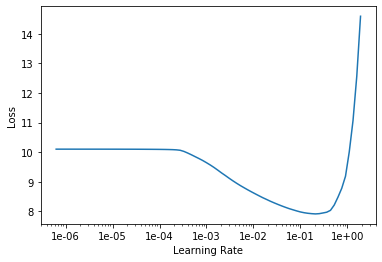

In [13]:
learn_lm.lr_find()
learn_lm.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,3.699338,3.281979,0.434519,01:17
1,2.417689,2.272296,0.581551,01:17
2,1.922076,2.044888,0.610264,01:17
3,1.720849,1.995373,0.616851,01:17
4,2.001456,2.017739,0.608403,01:17
5,1.984954,1.988648,0.613891,01:17
6,1.844407,1.948540,0.620233,01:17
7,1.757345,1.903846,0.629731,01:17
8,1.712033,1.865051,0.636776,01:17
9,1.704912,1.821844,0.642981,01:17


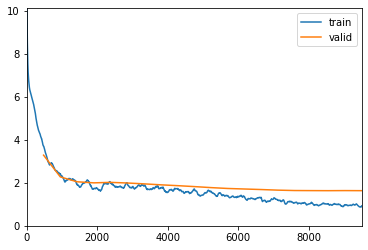

Better model found at epoch 0 with accuracy value: 0.43451905250549316.
Better model found at epoch 1 with accuracy value: 0.581550657749176.
Better model found at epoch 2 with accuracy value: 0.6102644205093384.
Better model found at epoch 3 with accuracy value: 0.6168509125709534.
Better model found at epoch 6 with accuracy value: 0.6202332377433777.
Better model found at epoch 7 with accuracy value: 0.6297307014465332.
Better model found at epoch 8 with accuracy value: 0.6367764472961426.
Better model found at epoch 9 with accuracy value: 0.6429812908172607.
Better model found at epoch 10 with accuracy value: 0.6541977524757385.
Better model found at epoch 11 with accuracy value: 0.6611643433570862.
Better model found at epoch 12 with accuracy value: 0.6665626764297485.
Better model found at epoch 13 with accuracy value: 0.6724798679351807.
Better model found at epoch 14 with accuracy value: 0.6794122457504272.
Better model found at epoch 15 with accuracy value: 0.6843210458755493.


In [14]:
max_lr = 1e-2
learn_lm.fit_one_cycle(20, max_lr=max_lr, moms=(0.8,0.7), callbacks=[callbacks.SaveModelCallback(learn_lm, every='improvement', monitor='accuracy', name='learn_lm')])

In [15]:
#Load the best version of the language model
learn_lm.load('learn_lm')
learn_lm.save_encoder('enc')

In [16]:
#Seeing what kind of text it generates
print(learn_lm.predict('Art. 1º Esta resolução visa',n_words=100,temperature=0.8))

Art. 1º Esta resolução visa a gestão geral e as demais disposições . Art . 9º As concessionárias e permissionárias de serviços públicos de energia elétrica deverão encaminhar à ANEEL , até o dia dez de cada mês , um plano de contas para o envio da documentação constante no Anexo i , conforme determinações disponíveis no sítio oficial da ANEEL na internet . ( Redação dada pela REN ANEEL 777 , de 04.07.2017 ) Art . 7º Esta Resolução entra em vigor na data de sua publicação . JOSÉ MÁRIO


## Now, extracting the vector representation of the texts

In [17]:
#loading de list with all the texts that I want to get the representation
normas = list(pd.read_csv('interesting_norms.csv',sep='|',encoding='utf-8')['Texto Extraído'])

In [18]:
len(normas)

496

In [19]:
data_lm = load_data('.',file='data_lm')
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult = 0.5, pretrained=False, callback_fns=ShowGraph)
learn_lm.load('learn_lm')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (1252 items)
x: LMTextList
xxbos xxup agência xxup nacional xxup de xxup energia xxup elétrica - xxup aneel xxup resolução xxmaj no 269 , xxup de 10 xxup de xxup junho xxup de 2003 . xxmaj autoriza a empresa xxmaj garcia xxmaj energética xxup s.a. - xxup gesa , a proceder a transferência para a xxmaj empresa xxup siif xxmaj alpha xxmaj ltda . da autorização objeto da xxmaj resolução nº 055 , de 8 de fevereiro de 2001 , e dá outras providências . o xxup diretor - xxup geral xxup da xxup agência xxup nacional xxup de xxup energia xxup elétrica - xxup aneel , no uso de suas atribuições regimentais , de acordo com deliberação da xxmaj diretoria , tendo em vista o disposto no art . 11 da xxmaj lei nº 9.074 , de 7 de julho de 1995 , regulamentada pelo xxmaj decreto nº 2.003 , de 10 de setembro de 1996 , no art . 26 da xxmaj lei nº 9.427 , de 26 de dezembro de 1996 , com a redação dada pelo art . 4º da xxmaj lei nº 9.648 , de 27 de maio 

In [20]:
#Here I get the vector representation of the text using the trained encoder
mbe = MultiBatchEncoder(70,1400,learn_lm.model[0])

def masked_concat_pool(outputs, mask):
    "Pool MultiBatchEncoder outputs into one vector [last_hidden, max_pool, avg_pool]."
    output = outputs[-1]
    avg_pool = output.masked_fill(mask[:, :, None], 0).mean(dim=1)
    avg_pool *= output.size(1) / (output.size(1)-mask.type(avg_pool.dtype).sum(dim=1))[:,None]
    max_pool = output.masked_fill(mask[:,:,None], -float('inf')).max(dim=1)[0]
    x = torch.cat([output[:,-1], max_pool, avg_pool], 1)
    return x

X = np.zeros((1,1200))
i=0
for norma in normas:
    xb,yb = learn_lm.data.one_item(norma)
    sentence = torch.cuda.LongTensor(xb.tolist()[0]).unsqueeze(0)
    raw_outputs, outputs, masks = mbe.forward(sentence)
    sentence_rep = masked_concat_pool(outputs, masks)
    X = np.append(X,sentence_rep,axis=0)
    if i % 100 == 0: print(str(i+1) + ' out of ' + str(len(normas)))
    i+=1

1 out of 496
101 out of 496
201 out of 496
301 out of 496
401 out of 496


In [21]:
#the first row is the initialized as zeros, i dont need it
X = np.delete(X, (0), axis=0)

In [22]:
X.shape

(496, 1200)

In [23]:
#save the texts repesentation in a file
np.save('X_LM', X)